In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/Users/user/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train=pd.read_csv('data/train.csv',parse_dates=['Date'])

In [3]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [4]:
weather=pd.read_csv('data/weather_cleaned.csv',parse_dates=['Date'])

In [5]:
spray=pd.read_csv('data/spray_cleaned.csv',parse_dates=['Date'])

In [6]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [7]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,51,56.0,0.0,2.0,448.0,1849.0,,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,51,57.0,0.0,3.0,NaN,NaN,,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,42,47.0,14.0,0.0,447.0,1850.0,BR,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,42,47.0,13.0,0.0,NaN,NaN,BR HZ,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,446.0,1851.0,,0.0,29.39,30.12,11.7,7,11.9


In [8]:
spray.tail()

,Date,Time,Latitude,Longitude
14289,2013-09-05,8:34:11 PM,42.006587,-87.812355
14290,2013-09-05,8:35:01 PM,42.006192,-87.816015
14291,2013-09-05,8:35:21 PM,42.006022,-87.817392
14292,2013-09-05,8:35:31 PM,42.005453,-87.817423
14293,2013-09-05,8:35:41 PM,42.004805,-87.817460


We attempt to get a working model using all available information and PCA

# Comment: any reason why use PCA?

In [9]:
#finding nearest station
def station(point):
    station1, station2 = [41.995, -87.933], [41.786, -87.752]  # Fixed coordinates for two stations
    if cdist([point], [station1,station2]).argmin() == 0: return 1 # return index of closest point
    return 2

In [10]:
train['Station'] = [station(x) for x in train[['Latitude','Longitude']].values]

In [11]:
combined=pd.merge(train,weather,on=['Date','Station'])

In [12]:
combined

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,"3900 North Springfield Avenue, Chicago, IL 606...",CULEX PIPIENS/RESTUANS,39,N SPRINGFIELD AVE,T228,"3900 N SPRINGFIELD AVE, Chicago, IL",41.951866,-87.725057,8,...,0.0,NaN,NaN,,0.0,29.40,30.04,4.1,9,4.6
10502,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,...,0.0,NaN,NaN,,0.0,29.40,30.04,4.1,9,4.6
10503,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,...,0.0,NaN,NaN,,0.0,29.40,30.04,4.1,9,4.6
10504,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,...,0.0,NaN,NaN,,0.0,29.40,30.04,4.1,9,4.6


In [13]:
combined=pd.read_csv('data/combined.csv',parse_dates=['Date'])

In [14]:
#geometry only used for plotting in EDA
combined.drop('geometry',inplace=True,axis=1)

In [15]:
#beat baseline
combined['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [16]:
combined['CodeSum'].unique()

array(['BR HZ', 'RA BR', 'TSRA BR HZ VCTS', ' ', 'TSRA RA BR VCTS',
       'TS TSRA RA BR HZ VCTS', 'DZ BR', 'RA BR HZ', 'HZ', 'VCTS',
       'TSRA RA DZ BR HZ', 'TSRA BR HZ', 'TSRA RA BR', 'TS TSRA RA BR',
       'BR', 'TSRA RA', 'TSRA HZ', 'TSRA', 'RA', 'TS TSRA BR', 'RA DZ BR',
       'TS TSRA BR HZ', 'TS TSRA RA VCTS', 'TSRA BR', 'TS BR', 'TS',
       'FG BR HZ', 'TS TSRA RA FG BR HZ'], dtype=object)

In [17]:
# making get dummies for CodeSum
words=[i.split(' ') for i in combined['CodeSum'].unique()]
words=[x for l in words for x in l]

In [18]:
pd.Series(words).value_counts().index

Index(['BR', 'TSRA', 'RA', 'HZ', 'TS', 'VCTS', 'DZ', 'FG', ''], dtype='object')

In [19]:
for col in pd.Series(words).value_counts().index:
    col_list=[1 if np.isin(i,col) else 0 for i in combined['CodeSum']]
    combined[col] = col_list

In [20]:
#proof my 'get dummies' worked
combined.TS.unique()

array([0, 1])

In [21]:
combined.drop('CodeSum',axis=1,inplace=True)

In [22]:
combined['Month'] = combined['Date'].dt.month
combined['Year']=combined['Date'].dt.year
combined.drop('Date',axis=1,inplace=True)

In [23]:
# in eda+outside research we realised that mostly PIPIENS/RESTUANS has the virus 
# so we just check whether species is pipens or restuans
combined['Species']=combined['Species'].str.contains('PIPENS|RESTUANS')

In [24]:
# in eda we identified a danger zone...we mark if the place is within it
combined['danger']=0
for indice,(lat,long) in combined[['Latitude', 'Longitude']].iterrows():
    if ((41.89 <= lat <= 42.02)&(-87.93 <= long <= -87.67)):
            combined.loc[indice,'danger']=1
combined['danger_and_species']=combined.danger*combined.Species

In [25]:
for i in combined.columns[combined.dtypes=='object']:
    print(combined[i].value_counts())

ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA         750
South Doty Avenue, Chicago, IL, USA                                          542
South Stony Island Avenue, Chicago, IL, USA                                  314
4100 North Oak Park Avenue, Chicago, IL 60634, USA                           185
4200 West 127th Street, Alsip, IL 60803, USA                                 183
                                                                            ... 
3400 West 77th Street, Chicago, IL 60652, USA                                  7
5500 South Doctor Martin Luther King Junior Drive, Chicago, IL 60637, USA      5
9600 South Longwood Drive, Chicago, IL 60643, USA                              5
2900 West 85th Street, Chicago, IL 60652, USA                                  3
2100 South Hamlin Avenue, Chicago, IL 60623, USA                               2
Name: Address, Length: 138, dtype: int64
 W OHARE AIRPORT       750
 S DOTY AVE            542
 S STONY ISLAN

In [26]:
# drop address-related columns since we got long,lat, NumMosquitos not given in test set
combined.drop(['AddressNumberAndStreet','Trap','NumMosquitos','AddressAccuracy','Address','spray_times','Street'],axis=1,inplace=True)

In [27]:
combined.columns

Index(['Species', 'Block', 'Latitude', 'Longitude', 'WnvPresent', 'Station',
       'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'Sunrise', 'Sunset', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'BR', 'TSRA', 'RA', 'HZ', 'TS',
       'VCTS', 'DZ', 'FG', '', 'Month', 'Year', 'danger',
       'danger_and_species'],
      dtype='object')

In [28]:
obj_list=combined.columns[combined.dtypes=='object']
obj_list

Index([], dtype='object')

In [29]:
combined=pd.get_dummies(combined,columns=obj_list.tolist(),drop_first=False)

In [30]:
def transform_test(test):
    words=[i.split(' ') for i in test['CodeSum'].unique()]
    words=[x for l in words for x in l]
    for col in pd.Series(words).value_counts().index:
        col_list=[1 if np.isin(i,col) else 0 for i in test['CodeSum']]
        test[col] = col_list
    test.drop('CodeSum',axis=1,inplace=True)
    test['Date']=pd.to_datetime(test['Date'])
    test['Month'] =test['Date'].dt.month
    test['Year']=test['Date'].dt.year
    # test has unspecified species... could be pipen restuans
    test['Species']=test['Species'].str.contains('PIPENS|RESTUANS|UNSPECIFIED')
    test['danger']=0
    for indice,(lat,long) in test[['Latitude', 'Longitude']].iterrows():
        if ((41.89 <= lat <= 42.02)&(-87.93 <= long <= -87.67)):
            test.loc[indice,'danger']=1
    test['danger_and_species']=test.danger*test.Species        
    test.drop(['Date','AddressNumberAndStreet','Trap','AddressAccuracy','Address','Street'],axis=1,inplace=True)
    test=pd.get_dummies(test,columns=test.columns[test.dtypes=='object'].tolist())
    return test

In [31]:
df_list=[]

# Comment: this modelling notebook bit is quite hard to read.. not sure why df_list or obj_list were created, as of this moment, probably for use later. But should at least include more comments and annotations.

In [32]:
combined.dropna(axis='columns',inplace=True)
X = combined.drop('WnvPresent',axis=1)
y = combined['WnvPresent']

In [33]:
# DEFINING A FUNCTION THAT WILL RUN MULTIPLE MODELS AND GRIDSEARCH FOR BEST PARAMETERS

def gridsearch_multi(steps_titles, steps_list, pipe_params):
    
    #DEFINING X and y
    combined.dropna(axis='columns',inplace=True)
    X = combined.drop('WnvPresent',axis=1)
    y = combined['WnvPresent']
    #TRAIN-TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)
    # DATAFRAME TO DISPLAY RESULTS
    gs_results = pd.DataFrame(columns=['model','AUC Score', 'precision', 'recall', 
                                       'best_params', 'best score', 'confusion matrix', 
                                       'train_accuracy','test_accuracy','baseline_accuracy', 'f1-score'])

    # FOR LOOP THROUGH STEPS LIST
    for i in range(len(steps_list)):
        # INSTATIATE PIPELINE
        pipe = Pipeline(steps=steps_list[i])
        # INSTANTIATE GRIDSEARCHCV WITH PARAMETER ARGUMENT
        gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
        gs.fit(X_train, y_train)
        
        #GETTING PREDICTIONS FROM MODEL
        pred = gs.predict(X_test)
        
        # DEFINE CONFUSION MATRIX ELEMENTS
        tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
        
        #CALCULATING AREA UNDER THE CURVE 
        auc = roc_auc_score(y_test, pred)
        recall=tp/(tp+fp)
        precision=tp/(tn+tp)
        #DEFINE DATAFRAME COLUMNS
        model_results = {}
        model_results['model'] = steps_titles[i]
        model_results['AUC Score'] = auc
        model_results['recall (sensitivity)']= recall
        model_results['best params'] = gs.best_params_
        model_results['best score'] = gs.best_score_
        model_results['confusion matrix']={"TP": tp,"FP":fp, "TN": tn, "FN": fn}
        model_results['train accuracy'] = gs.score(X_train, y_train)
        model_results['test accuracy'] = gs.score(X_test, y_test)
        model_results['baseline accuracy'] = 0.95        
        model_results['precision']= precision
        model_results['f1-score']= 2*(recall*precision)/(recall+precision)


        #APPEND RESULTS TO A NICE DATAFRAME
        df_list.append(model_results) 
        pd.set_option("display.max_colwidth", 200)
    return (pd.DataFrame(df_list)).round(2)

In [34]:
steps_titles = ['RF','GradientTrees','SVM','SS+PCA+SVM']

# CODE FOR PIPELINE TO INSTATIATE MODELS
steps_list = [ 
    [('rf', BaggingClassifier(RandomForestClassifier(random_state=25,max_depth=3),random_state=25,n_estimators=100,n_jobs=-1))],
    [('trees', GradientBoostingClassifier(random_state=25,n_estimators=500,max_depth=3,
                             min_samples_leaf=2))],
    # need to set balance because we have imblanced classes
    [('svc', SVC(random_state=25,class_weight='balanced',gamma='auto'))],
    [('ss',StandardScaler()),('pca',PCA(1)),('svc', SVC(random_state=25,class_weight='balanced',gamma='auto',kernel='rbf'))]
]

# LIST OF PARAMETER DICTIONARIES
pipe_params = [
    {'rf__bootstrap_features':[True,False]},
    {'trees__learning_rate':np.linspace(0.1,1,3),'trees__max_features':['sqrt',None]},
    {'svc__C':np.linspace(0.01,1,3),'svc__kernel':['linear','rbf']},
    {'svc__C':np.linspace(0.01,1,3)}]


# Comment: but for PCA, wouldn't it be better NOT to state the number of components i.e. PCA()? instead, after PCA(), plot % explained variance against number of components and then choose the optimal number of components?

In [35]:
gridsearch_multi(steps_titles, steps_list, pipe_params)

/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,model,AUC Score,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,baseline accuracy,precision,f1-score
0,RF,0.50,NaN,{'rf__bootstrap_features': True},0.95,"{'TP': 0, 'FP': 0, 'TN': 2489, 'FN': 138}",0.95,0.95,0.95,0.00,NaN
1,GradientTrees,0.53,0.35,"{'trees__learning_rate': 0.1, 'trees__max_features': 'sqrt'}",0.94,"{'TP': 8, 'FP': 15, 'TN': 2474, 'FN': 130}",0.95,0.94,0.95,0.00,0.01
2,SVM,0.68,0.13,"{'svc__C': 1.0, 'svc__kernel': 'rbf'}",0.80,"{'TP': 79, 'FP': 526, 'TN': 1963, 'FN': 59}",0.81,0.78,0.95,0.04,0.06
3,SS+PCA+SVM,0.57,0.07,{'svc__C': 0.01},0.53,"{'TP': 89, 'FP': 1251, 'TN': 1238, 'FN': 49}",0.51,0.51,0.95,0.07,0.07


# Comment: very programmatic and efficient

# Comment: but are there any reasons why you chose these models to train/test on? or any reasons why never consider LogReg etc?

In [36]:
# gradient Tree Worked best since recall is high even if auc is high the bias is super poor for SVM
gb=GridSearchCV(GradientBoostingClassifier(n_estimators=500,max_depth=3,random_state=42),
                {'learning_rate':np.linspace(0.1,1,3),'max_features':['sqrt',None]},scoring='roc_auc')            
gb.fit(X,y)

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=500,
                                                  n_iter_no_change=None,
                                                  pre

In [37]:
features=gb.best_estimator_.feature_importances_

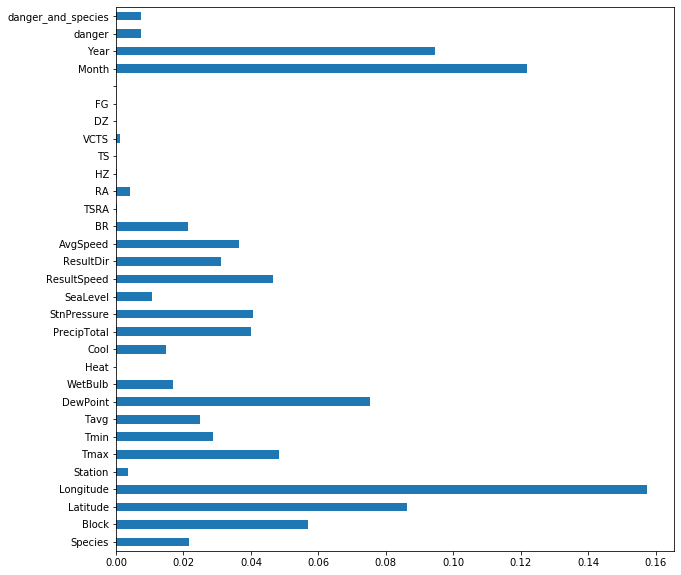

In [38]:
plt.figure(figsize=(10,10))
pd.Series(features,index=X.columns).plot(kind='barh')

# Comment: perhaps sorting it will make it easier to read

In [39]:
# importing data for kaggle submission
weather=pd.read_csv('data/weather_cleaned.csv')
test=pd.read_csv('data/test.csv')
test['Station'] = [station(x) for x in test[['Latitude','Longitude']].values]
test=pd.merge(test,weather,on=['Date','Station'])

In [40]:
# submission for Kaggle
test=transform_test(test)

In [41]:
# columns train have but test dun have and columns test have train doesnt have
print(combined.columns[np.isin(combined.columns,test.columns,invert=True)],
      test.columns[np.isin(test.columns,combined.columns,invert=True)])

Index(['WnvPresent', 'FG'], dtype='object') Index(['Id', 'Sunrise', 'Sunset', 'BCFG', 'FG+'], dtype='object')


In [42]:
extra_col=test.columns[np.isin(test.columns,combined.columns,invert=True)]
# set FG ,spray_times to 0
test['FG']=0
# remove extra features from test
X_test=test.drop(extra_col,axis=1)
# sort columns to match the combined dataframe
X_test = X_test.reindex(columns=combined.drop('WnvPresent',axis=1).columns)

In [43]:
X_test.isnull().sum().sum()

0

In [44]:
kaggle_result=gb.predict_proba(X_test)[:,1] 

In [45]:
#kaggle_result[(X_test.Species[X_test.Species==False]).index]=0
WnvPresent=pd.Series(kaggle_result,name='WnvPresent')
kaggle=pd.DataFrame(columns=[test['Id'],WnvPresent]).T
kaggle.to_csv('data/kaggle.csv')

![](assets/Kaggle.JPG)

# Comment: generally, the WHOLE project is quite well done, but unfortunately this last bit of the modelling phase pulls down the overall mark slightly due to less-than-ideal formatting and readability.

# Comment: programmatically, everything is great, but the commenting/explaining (and formatting of course) can be much more thorough at the final part

# Comment: for example, what is F1-score? why was it included in the table as a form of evaluation metric? i know it wasn't used in the end as a metric, but the fact that you included it at all in the summary table of results means it should be explained a bit somewhat.

# Comment: more interpretation and explanation should be done in feature importance (none was given in this notebook, and only a few lines were mentioned in the README.md)